Problem: cannot use workers here because Your generator is NOT thread-safe

Yes, it still works but slow

In [1]:
import os, sys, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from imgaug import augmenters as iaa
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
sample_submission = pd.read_csv("./input/sample_submission.csv")
print('sample_submission.shape:', sample_submission.shape)
sample_submission.head()

sample_submission.shape: (11702, 2)


,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0


In [3]:
train = pd.read_csv("./input/train.csv")

print('train.shape:', train.shape)
train.head()

train.shape: (31072, 2)


,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


# Load dataset info

In [4]:
path_to_train = './input/train_images/'
train = pd.read_csv('./input/train.csv')

train_dataset_info = []

for name, labels in zip(train['Id'], train['Target'].str.split(' ')):
    train_dataset_info.append({
        'path': path_to_train + str(name),
        'labels': np.array([int(label) for label in labels])})

train_dataset_info = np.array(train_dataset_info)

In [5]:
print('len(train_dataset_info):', len(train_dataset_info))
train_dataset_info

len(train_dataset_info): 31072


array([{'path': './input/train_images/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0', 'labels': array([16,  0])},
       {'path': './input/train_images/000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0', 'labels': array([7, 1, 2, 0])},
       {'path': './input/train_images/000a9596-bbc4-11e8-b2bc-ac1f6b6435d0', 'labels': array([5])},
       ...,
       {'path': './input/train_images/fff189d8-bbab-11e8-b2ba-ac1f6b6435d0', 'labels': array([7])},
       {'path': './input/train_images/fffdf7e0-bbc4-11e8-b2bc-ac1f6b6435d0', 'labels': array([25,  2, 21])},
       {'path': './input/train_images/fffe0ffe-bbc0-11e8-b2bb-ac1f6b6435d0', 'labels': array([2, 0])}],
      dtype=object)

# Split into train, val

In [8]:
VALIDATION_SPLIT = 0.1

In [9]:
from sklearn.model_selection import train_test_split

train_id, val_id, train_targets, val_target = train_test_split(
    train['Id'], train['Target'], test_size=VALIDATION_SPLIT, random_state=42)

print('len(train_id):', len(train_id))
print('len(val_id):', len(val_id))

len(train_id): 27964
len(val_id): 3108


# Define Datagenerator

In [28]:
class data_generator(keras.utils.Sequence):
    
    def create_train(dataset_info, batch_size, shape, augument=True):
        assert shape[2] == 3
        while True:
            random_indexes = np.random.choice(len(dataset_info), batch_size)
            batch_images = np.empty((batch_size, shape[0], shape[1], shape[2]))
            batch_labels = np.zeros((batch_size, 28))
            for i, idx in enumerate(random_indexes):
                image = data_generator.load_image(
                    dataset_info[idx]['path'], shape)   
                if augument:
                    image = data_generator.augment(image)
                batch_images[i] = image
                batch_labels[i][dataset_info[idx]['labels']] = 1
            yield batch_images, batch_labels
            
    
    def load_image(path, shape):
        R = np.array(Image.open(path+'_red.png'))
        G = np.array(Image.open(path+'_green.png'))
        B = np.array(Image.open(path+'_blue.png'))
        Y = np.array(Image.open(path+'_yellow.png'))

        image = np.stack((
            R/2 + Y/2, 
            G/2 + Y/2, 
            B),-1)
        
        image = cv2.resize(image, (shape[0], shape[1]))
        image = np.divide(image, 255)
        return image  
                
            
    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),         #flip horizontally
                iaa.Flipud(0.5),         #flip upside down
            ])], random_order=True)
        
        image_aug = augment_img.augment_image(image)
        return image_aug

## Show data

In [29]:
# create train datagen
train_datagen = data_generator.create_train(
    dataset_info = train_dataset_info,
    batch_size = 5, 
    shape = (299,299,3), 
    augument = True)

min: 0.0, max: 1.0


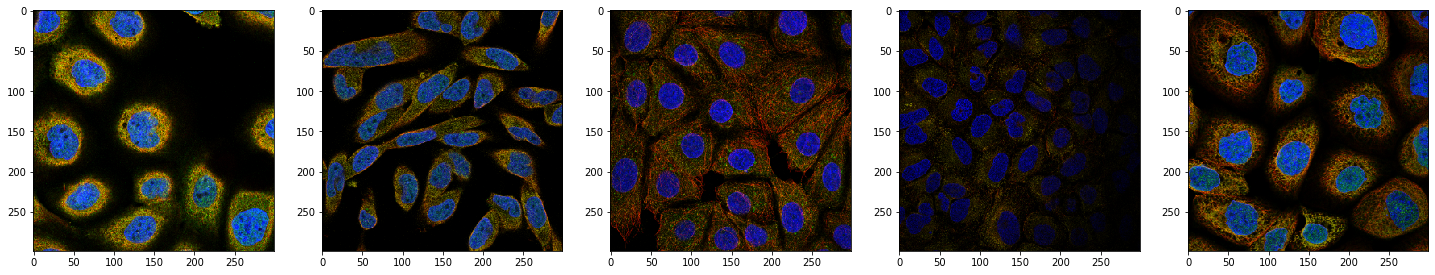

In [33]:
images, labels = next(train_datagen)

fig, ax = plt.subplots(1,5,figsize=(25,5))
for i in range(5):
    ax[i].imshow(images[i])
print('min: {0}, max: {1}'.format(images.min(), images.max()))

# Create Data Generator

In [34]:
INPUT_SHAPE = (299,299,3)
BATCH_SIZE = 10

In [35]:
train_datagen = data_generator.create_train(
    train_dataset_info[train_id.index], BATCH_SIZE, INPUT_SHAPE, augument=False)

val_datagen = data_generator.create_train(
    train_dataset_info[val_id.index], 256, INPUT_SHAPE, augument=False)

In [36]:
train_steps = int(np.ceil(len(train_id) / BATCH_SIZE))
validation_steps = int(np.ceil(len(val_id) / BATCH_SIZE))
print('train_steps:', train_steps)                         # len(train_generator)
print('validation_steps:', validation_steps)               # len(validation_generator)

train_steps: 2797
validation_steps: 311


# Model in Keras

In [17]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.models import Model
from keras.applications import InceptionResNetV2
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LambdaCallback
from keras.callbacks import Callback
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import tensorflow as tf
import keras

Using TensorFlow backend.


In [18]:
# Metric: F1

def f1(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [19]:
def create_model(input_shape, n_out):
    
    pretrain_model = InceptionResNetV2(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape)  
    pretrain_model.trainable = False
    
    input_tensor = Input(shape=input_shape)
    bn = BatchNormalization()(input_tensor)
    x = pretrain_model(bn)
    x = Conv2D(128, kernel_size=(1,1), activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(n_out, activation='sigmoid')(x)
    
    model = Model(inputs=[input_tensor], outputs=[output])
    
    model.compile(
        loss='binary_crossentropy', 
        optimizer=Adam(lr=1e-3),
        metrics=['acc', f1])
    
    model.summary()
    
    return model

In [20]:
def load_model():

    dependencies = {
     'f1': f1
    }
    
    model = load_model('./model/protein_InceptionResNetV2_valloss.h5', custom_objects = dependencies)
    model.layers[0].trainable = False
    
    model.compile(
        loss = 'binary_crossentropy',
        optimizer = Adam(lr=0.00000001),
        metrics = ['acc', f1])
    
    model.summary()
    
    return model

In [21]:
%%time

keras.backend.clear_session()

# Create model
model = create_model(
    input_shape=(299,299,3),
    n_out=28)

# Load model
# model = load_model()









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 299, 299, 3)       0         
_________________________________________________________________
batch_normalization_204 (Bat (None, 299, 299, 3)       12        
_________________________________________________________________
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
conv2d_204 (Conv2D)          (None, 8, 8, 128)         196736    
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
________________________________________________________

In [22]:
# Define callbacks (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
# ModelCheckpoint: Save the (best) model weights after every epoch

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
             EarlyStopping(monitor='val_loss', patience=6, min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=2, cooldown=1, min_lr=1e-6),
             ModelCheckpoint(filepath='./model/protein_InceptionResNetV2_valloss.h5', monitor='val_loss',
                             save_best_only=True, save_weights_only=False)
            ]

In [23]:
EPOCHS = 1

In [37]:
%%time
# Train the model

history = model.fit_generator(
                train_datagen,
                steps_per_epoch = train_steps,
                epochs = EPOCHS,
                validation_data = val_datagen,
                validation_steps = validation_steps,
                callbacks = callbacks,
                workers=4,              '''Problem: cannot use workers because Your generator is NOT thread-safe'''
                #max_queue_size=10,     '''Yes, it still works but slow'''
                )

Epoch 1/1
   1/2797 [..............................] - ETA: 2:06:31 - loss: 0.1810 - acc: 0.9393 - f1: 0.0744

RuntimeError: Your generator is NOT thread-safe.Keras requires a thread-safe generator when`use_multiprocessing=False, workers > 1`.For more information see issue #1638.

In [ ]:
# Save model
model.save('./model/protein_InceptionResNetV2_valloss.h5')

In [ ]:
print(history.history.keys())

# Model Evaluation

## 1) Plot learning rate, loss, f1, acc

In [ ]:
def show_history(history):
    fig, ax = plt.subplots(1, 4, figsize=(15,5))
    ax[0].set_title('learning rate')
    ax[0].plot(history.epoch, history.history["lr"], label="lr")
    #ax[0].xlabel('Epoch')
    #ax[0].ylabel('Learning Rate')

    ax[1].set_title('loss')
    ax[1].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[1].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    
    ax[2].set_title('f1')
    ax[2].plot(history.epoch, history.history["f1"], label="Train f1")
    ax[2].plot(history.epoch, history.history["val_f1"], label="Validation f1")
    
    ax[3].set_title('acc')
    ax[3].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[3].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[3].legend()

## 2) Loss and dice_coef (val)

In [ ]:
%%time

# val_datagen.reset()
# score = model.evaluate(x_val, y_val)
score = model.evaluate_generator(val_datagen, 
                                 steps = validation_steps
                                )
print("loss:", score[0])
print("metric (acc):", score[1])
print("metric (f1):", score[2])

## 3) Confusion Matrix

In [ ]:
%%time

# validation_generator.reset()
# y_val_pred = model.predict_classes(x_val)
y_val_pred_prob = model.predict_generator(val_datagen, 
                                          steps = validation_steps
                                         )

In [ ]:
print('y_val_pred_prob.shape:', y_val_pred_prob.shape)
y_val_pred_prob

In [ ]:
y_val_pred = (y_val_pred_prob > 0.5).astype(np.uint8)
y_val_pred